In [1]:
import numpy
import numpy as np
import csv

import pyscf
from pyscf import gto, fci
from pyscf.lo.orth import orth_ao

import eph

def calculate_energy(bond_length, basis_set, with_eph=False):
    m = pyscf.gto.Mole()
    m.verbose = 0
    m.atom = f'H 0 0 0; Li 0 0 {bond_length}'
    m.unit = 'B'
    m.basis = basis_set
    m.build()

    nelec = m.nelec
    coeff_lo = orth_ao(m, 'meta_lowdin')
    nao, norb = coeff_lo.shape

    d_ao = m.intor('int1e_r', comp=3).reshape(3, nao, nao)

    if not with_eph:
        fci_obj = fci.FCI(m, mo=coeff_lo, singlet=False)
        fci_obj.nroots = 20
        fci_obj.max_cycle = 1000
        fci_obj.conv_tol = 1e-6
        fci_obj.verbose = 0
        e0, c0 = fci_obj.kernel()

    else:
        nmode = 1
        nph_max = 3
        state_1 = 0
        state_2 = 2

        omega = 0.1
        h1p = numpy.zeros((nmode, nmode))
        h1p[0, 0] = omega

        alph = 0.005
        dd = numpy.ones(3) # numpy.einsum('pq,xpq->x', tdm_lo, d_lo)

        vv = dd * alph / numpy.linalg.norm(dd)
        vv = vv.reshape(nmode, 3)
        h1e1p_ao = numpy.einsum('Ix,xpq->pqI', vv, d_ao)

        eph_obj = eph.FCI(m, mo=coeff_lo, h1p=h1p, h1e1p=h1e1p_ao, nph_max=3, singlet=False)
        eph_obj.max_cycle = 1000
        eph_obj.conv_tol = 1e-6
        e0, c0 = eph_obj.kernel(nroots=20)

    energies = [e0[istate] for istate in range(10)]
    return energies

def main(with_eph=False, output_file='lih.csv'):
    bond_lengths = np.linspace(1.0, 5.0, 26)
    basis_set = '631g'
    all_energies = []

    for bond_length in bond_lengths:
        energies = calculate_energy(bond_length, basis_set, with_eph)
        all_energies.append([bond_length] + energies)

    with open(output_file, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['bond_length', 'e0', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'e9'])
        writer.writerows(all_energies)

    return np.asarray(all_energies)

main(with_eph=False, output_file='./lih.csv')
main(with_eph=True, output_file='./lih-qed.csv')

array([[ 1.        , -7.26232486, -7.21135156, -7.1898756 , -7.16577027,
        -7.16488703, -7.16369573, -7.12625718, -7.12542063, -7.11156702,
        -7.09031851],
       [ 1.16      , -7.46689393, -7.39812661, -7.38015701, -7.36764698,
        -7.35334603, -7.35228981, -7.3223364 , -7.32217378, -7.29848018,
        -7.28054767],
       [ 1.32      , -7.61692535, -7.53272829, -7.51930327, -7.51432309,
        -7.48901664, -7.48787487, -7.4632886 , -7.46311531, -7.43337858,
        -7.42063968],
       [ 1.48      , -7.72713298, -7.63121742, -7.62833113, -7.61471375,
        -7.58838517, -7.58720709, -7.56597231, -7.56564344, -7.53219496,
        -7.52933086],
       [ 1.64      , -7.80793652, -7.70894027, -7.7037882 , -7.6879307 ,
        -7.6615491 , -7.66036072, -7.64127266, -7.64087549, -7.60976532,
        -7.60498351],
       [ 1.8       , -7.86698794, -7.76793175, -7.75758158, -7.74202341,
        -7.71565061, -7.71446482, -7.69684988, -7.69643212, -7.66866293,
        -7.658

In [25]:
import csv
import matplotlib.pyplot as plt

def read_csv_file(filename):
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        header = next(reader)  # Skip the header
        
        bond_lengths = []
        energies = [[] for _ in range(10)]

        for irow, row in enumerate(reader):
            bond_lengths.append(float(row[0]))
            for i, energy in enumerate(row[1:]):
                energies[i].append(float(energy))

    return bond_lengths, energies

In [50]:
bond_lengths, energies_1 = read_csv_file('./lih.csv')
bond_lengths, energies_2 = read_csv_file('./lih-qed.csv')

(-8.02, -7.8)

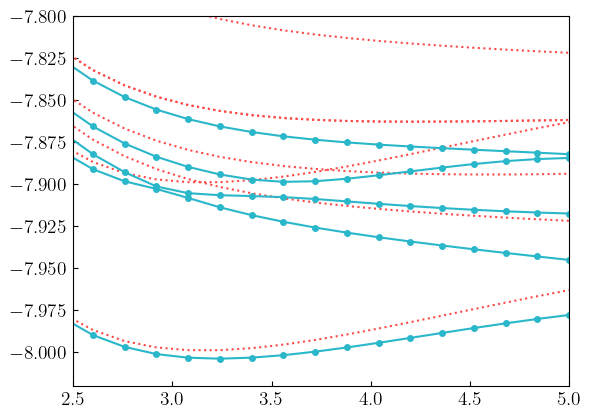

In [53]:
import plot_utils
fig, ax = plt.subplots()

for i, energy_list in enumerate(energies_1):
    if i == 5:
        break

    ax.plot(bond_lengths, numpy.array(energy_list)+0.0, label=f'State {i}', marker='None', linestyle=':', markersize=4, color=plot_utils.colors[0])
    ax.plot(bond_lengths, numpy.array(energy_list)+0.1, label=f'State {i}', marker='None', linestyle=':', markersize=4, color=plot_utils.colors[0])
    ax.plot(bond_lengths, numpy.array(energy_list)+0.2, label=f'State {i}', marker='None', linestyle=':', markersize=4, color=plot_utils.colors[0])

for i, energy_list in enumerate(energies_2):
    if i == 5:
        break
    ax.plot(bond_lengths, energy_list, label=f'State {i}', marker='o', linestyle='-', markersize=4, color=plot_utils.colors[1])

ax.set_xlim(2.5, 5.0)
ax.set_ylim(-8.02, -7.80)